准备环境

In [1]:
import random

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from qutrunk.circuit import QCircuit
from qutrunk.circuit.gates import Rx, Ry, Rz, PauliZ

定义线路相关函数

In [2]:
def datapoint_circuit(rotations):
    alpha0, alpha1, alpha2 = [float(f) for f in rotations]
    circuit = QCircuit()
    qreg = circuit.allocate(1)
    Rx(alpha0) * qreg[0]
    Ry(alpha1) * qreg[0]
    Rz(alpha2) * qreg[0]
    return circuit


def model_circuit():
    circuit = QCircuit()
    q = circuit.allocate(1)
    angles = ["theta-0", "theta-1", "theta-2"]
    params = circuit.create_parameters(angles)

    Rz(params[0]) * q[0]
    Ry(params[1]) * q[0]
    Rx(params[2]) * q[0]

    return circuit


def expectation():
    circuit = QCircuit()
    qreg = circuit.allocate(1)
    return PauliZ(qreg[0])


def join_circuit(datapoint_cir, model_cir, inputs):
    params = {"theta-" + str(i): inputs[i] for i in range(len(inputs))}
    model_cir = model_cir.bind_parameters(params)
    datapoint_cir.append_circuit(model_cir)
    return datapoint_cir

定义梯度计算类

In [3]:
class CustomGradientTape:
    def __init__(self, inputs, exp_op, shift=np.pi / 2):
        self.inputs = inputs
        self.exp_op = exp_op
        self.shift = shift

    def gradient(self, loss, var_list):
        params = [var.numpy() for var in var_list]

        gradients = []
        for i in range(len(params)):
            shift_right = np.copy(params)
            shift_right[i] += self.shift
            shift_left = np.copy(params)
            shift_left[i] -= self.shift

            circuit = join_circuit(datapoint_circuit(self.inputs), model_circuit(), shift_right)
            expectation_right = -1 * circuit.expval_pauli(self.exp_op)

            circuit = join_circuit(datapoint_circuit(self.inputs), model_circuit(), shift_left)
            expectation_left = -1 * circuit.expval_pauli(self.exp_op)

            gradient = expectation_right - expectation_left
            gradients.append(tf.convert_to_tensor(gradient, dtype=tf.float32))
        return gradients

自定义层

In [4]:
class ControlledPQC(tf.keras.layers.Layer):

    def __init__(self, optimizer, exp_op, var_list, grad):
        super(ControlledPQC, self).__init__()
        self.optimizer = optimizer
        self.exp_op = exp_op
        self.var_list = var_list

        self.grad = grad

    def call(self, inputs):
        params_list = [var.numpy() for var in self.var_list]
        circuit = join_circuit(datapoint_circuit(inputs), model_circuit(), params_list)
        loss = -1 * circuit.expval_pauli(self.exp_op)
        self.optimizer.minimize(loss, self.var_list, self.grad)

        return loss

运行模型

In [9]:
ITR = 200
LR = 0.02
rand = random.Random()
random_rotations = tf.convert_to_tensor(np.random.uniform(0, 2 * np.pi, 3))
op = expectation()

opt = tf.keras.optimizers.Adam(learning_rate=LR)

control_params = [tf.Variable(rand.uniform(0, 2 * np.pi)) for _ in range(3)]
model = ControlledPQC(opt, op, control_params, CustomGradientTape(random_rotations, op))

loss_list = []
for it in range(ITR):
    ls = model(random_rotations)
    loss_list.append(ls)
    if it % 10 == 0:
        print(f"{it}: {ls:.4f}")


0: -0.7065
10: -0.9348
20: -0.9986
30: -0.9928
40: -0.9974
50: -0.9997
60: -0.9996
70: -0.9999
80: -1.0000
90: -1.0000
100: -1.0000
110: -1.0000
120: -1.0000
130: -1.0000
140: -1.0000
150: -1.0000
160: -1.0000
170: -1.0000
180: -1.0000
190: -1.0000


展示结果

Text(0, 0.5, 'loss')

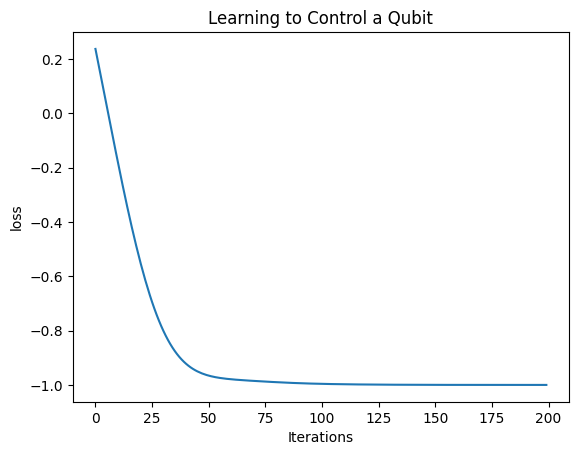

In [6]:
plt.plot(loss_list)
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("loss")